In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join

Joker is a catalog of spectroscopic binaries from APOGEE by Adrian Price-Whelan

Data access
https://www.sdss.org/dr17/data_access/value-added-catalogs/?vac_id=orbital-parameter-samplings-of-apogee-2-stars-from-the-joker

Column info
https://data.sdss.org/datamodel/files/APOGEE_THEJOKER/apJoker-metadata.html

Paper (with DR16)
https://ui.adsabs.harvard.edu/abs/2020ApJ...895....2P/abstract

Our goal here is to cross-match this table with Gaia DR3. We ultimately want to make a table where each row is one star, and it has information from APOGEE, gaia_source, nss_two_body_orbit, and astrophysical_parameters.
We will accomplish this by making a table to upload to the Gaia archive, then matching both with source ID and coordinate crossmatch.

In [2]:
# allStarLite: https://www.sdss.org/dr17/irspec/spectro_data/#SummaryCatalogs
apogee = Table.read("/Users/alexji/APOGEE/allStarLite-dr17-synspec_rev1.fits")
apogee = apogee[apogee["EXTRATARG"] == 0] # https://www.sdss.org/dr17/irspec/catalogs/
joker = Table.read("apJoker-metadata.fits")

In [3]:
?join

The Joker catalog does not have RA, Dec, or EDR3 Source ID. So we need to join it with the main APOGEE table.
We can use the APOGEE_ID column to join the tables.

When doing this, be careful about duplicate column names. astropy by default calls columns x_1 and x_2 from the two tables when they're duplicated, but it's easier for you if you get rid of duplicate columns (e.g. `tab.remove_columns` will let you specify a list to remove). However, the only duplicate column in these tables is APOGEE_ID, which is the key we are joining on.

In [4]:
mergetab = join(joker, apogee, "APOGEE_ID", "inner")

Check that the lengths make sense: we want the same or fewer numbers in mergetab as we do in the other two tables. These numbers makes sense, not all APOGEE spectra have multiple RV observations.

In [5]:
len(mergetab), len(joker), len(apogee)

(251561, 358350, 372458)

Make sure there is a unique ID for later joining after you do the Gaia query.

In [6]:
np.unique(mergetab["APOGEE_ID"].size), len(mergetab)

(array([251561]), 251561)

We'll write out a smaller table with just crucial information for joining to upload to the Gaia archive.

For tutorial, get just the first 1000:
https://www.dropbox.com/s/r2sc28ejl5ttl9c/thejoker_coords_short.csv?dl=0

For the full catalog:
https://www.dropbox.com/s/jkbg8grw3nb5brz/thejoker_coords.csv?dl=0

In [7]:
mergetab["APOGEE_ID","RA","DEC","GAIAEDR3_SOURCE_ID"].write("thejoker_coords.csv", overwrite=True)

In [8]:
elems = ["C","N","O","NA","MG","AL","SI","P","S","K","CA","TI","V","CR","MN","CO","NI","CU","CE"]
cols_to_keep = list(joker.colnames) + [
    "RA","DEC","J","H","K","SNR",
    "VHELIO_AVG","VSCATTER","VERR",
    "GAIAEDR3_SOURCE_ID","GAIAEDR3_PARALLAX","GAIAEDR3_PARALLAX_ERROR","GAIAEDR3_PMRA","GAIAEDR3_PMDEC",
    "TEFF","LOGG","M_H","FE_H","ALPHA_M","VMICRO","VSINI","TEFF_SPEC","LOGG_SPEC",
] + [x+"_FE" for x in elems]

In [9]:
mergetabwrite = mergetab[cols_to_keep]
mergetabwrite.write("joker_apogee.fits", overwrite=True)

Available at this dropbox link if you want to avoid the catalog munging (120MB):

https://www.dropbox.com/s/xatfx0m3ddl5owv/joker_apogee.fits?dl=0

In [10]:
np.array(mergetab.colnames)

array(['APOGEE_ID', 'n_visits', 'MAP_P', 'MAP_P_err', 'MAP_e',
       'MAP_e_err', 'MAP_omega', 'MAP_omega_err', 'MAP_M0', 'MAP_M0_err',
       'MAP_K', 'MAP_K_err', 'MAP_v0', 'MAP_v0_err', 'MAP_s', 'MAP_s_err',
       'MAP_t0_bmjd', 't_ref_bmjd', 'baseline', 'MAP_ln_likelihood',
       'MAP_ln_prior', 'max_unmarginalized_ln_likelihood',
       'max_phase_gap', 'periods_spanned', 'phase_coverage',
       'phase_coverage_per_period', 'unimodal', 'joker_completed',
       'mcmc_completed', 'mcmc_status', 'gelman_rubin_max',
       'constant_ln_likelihood', 'robust_constant_ln_likelihood',
       'robust_constant_mean', 'robust_constant_scatter',
       'robust_constant_success', 'robust_linear_ln_likelihood',
       'robust_linear_a', 'robust_linear_b', 'robust_linear_scatter',
       'robust_linear_success', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA',
       'DEC', 'GLON', 'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR',
       'AK_TARG', 'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV',
       'APOGE

# Option 1: match by source_id

1. Upload your user table (in this case, `thejoker_coords.csv`). In Search -> Advanced (ADQL) you can click the button with the up arrow to upload (mouseover to see what the buttons do). Give it a short but descriptive name (in my case I called it `joker`)
2. Once uploaded, on the left panel of different data tables scroll down to User tables and your table should be there (mine is `user_aji.joker`). 

Example query:
```
SELECT 
a.apogee_id,
b.ra, b.dec, b.parallax, b.parallax_error, b.parallax_over_error, b.pmra, b.pmdec, 
b.radial_velocity, b.radial_velocity_error,
b.phot_g_mean_mag, b.phot_bp_mean_mag, b.phot_rp_mean_mag,
b.teff_gspphot, b.logg_gspphot, b.mh_gspphot, b.distance_gspphot, b.ag_gspphot, b.ebpminrp_gspphot,
c.nss_solution_type, c.period, c.period_error, c.eccentricity, c.eccentricity_error, 
c.semi_amplitude_primary, c.semi_amplitude_primary_error, c.semi_amplitude_secondary, c.semi_amplitude_secondary_error,
c.mass_ratio, c.mass_ratio_error, c.goodness_of_fit, c.significance, c.g_luminosity_ratio
FROM user_aji.joker as a
INNER JOIN
gaiadr3.gaia_source_lite as b ON a.gaiaedr3_source_id = b.source_id
INNER JOIN
gaiadr3.nss_two_body_orbit as c ON b.source_id = c.source_id
```

The main parts of a query are:
```
SELECT <LIMIT N>
<column names>
FROM <table1>
<INNER/LEFT/RIGHT/OUTER/FULL> JOIN <table2> ON <condition>
WHERE
<condition1>
AND
<condition2>
```

In this case our conditions are just making sure the source IDs match, which you can enforce with JOIN, so there is no need for WHERE.

### Some general comments for SQL

I make a huge number of typos when writing SQL queries. If you click the "i" icon on the right of your job, it opens up some information about the query. If your query failed, you can click the "Error Summary" tab to see why it failed.
The most common error is "unresolved identifier" which lists how many are broken at the end; usually it means you made a typo or that column doesn't exist in the table you're asking for.

In general I like doing something like LIMIT 10 or 100 to start, to get an estimate of how long it'll take to query the whole table.

# Option 2: cross-match ra/dec, then match by source_id

1. Upload your user table if you haven't already.
2. In the left panel, scroll back to the user table. Click the checkbox next to your table then click the "Edit table" button at the top (the spreadsheet-looking document). Mark the columns that are RA and Dec.
3. Click the "Cross-match tables" button at the top (two stars). Using the dropdown menus, select the two tables you would like to cross match based on their RA and Dec. For Table A I used `user_aji.joker` and for Table B I used `gaiadr3.gaia_source`. I used radius = 1 arcsec which is usually pretty good though you can expand it if you need. It will always take the object with the closest position. Execute the crossmatch. (This is a special database operation and will fail if you did not mark columns an RA and Dec.)
4. Once it finishes running, you should have a new user table, e.g. `user_aji.xmatch_joker_gaia_source`. In my case I have three columns in this table: `gaia_source_source_id` which is the ID column of the ; `joker_joker_oid` which is a new ID created when I uploaded the table; and `separation` which is the separation between the sources in degrees (should always be less than 1 arcsec = 2.8e-4 degrees if you matched within 1 arcsec).
5. Now, do the query similar to above but adding the cross match table as a condition on the source ID. For example:

```
SELECT 
a.apogee_id,
b.ra, b.dec, b.parallax, b.parallax_error, b.parallax_over_error, b.pmra, b.pmdec, 
b.radial_velocity, b.radial_velocity_error,
b.phot_g_mean_mag, b.phot_bp_mean_mag, b.phot_rp_mean_mag,
b.teff_gspphot, b.logg_gspphot, b.mh_gspphot, b.distance_gspphot, b.ag_gspphot, b.ebpminrp_gspphot,
c.nss_solution_type, c.period, c.period_error, c.eccentricity, c.eccentricity_error, 
c.semi_amplitude_primary, c.semi_amplitude_primary_error, c.semi_amplitude_secondary, c.semi_amplitude_secondary_error,
c.mass_ratio, c.mass_ratio_error, c.goodness_of_fit, c.significance, c.g_luminosity_ratio
FROM user_aji.joker as a
INNER JOIN
user_aji.xmatch_joker_gaia_source as xm ON a.joker_oid = xm.joker_joker_oid
INNER JOIN
gaiadr3.gaia_source_lite as b ON a.gaiaedr3_source_id = xm.gaia_source_source_id
INNER JOIN
gaiadr3.nss_two_body_orbit as c ON xm.gaia_source_source_id = c.source_id
```

### WARNING
In general, cross-matching using coordinates can be a tricky process:
* stars move, so you need to adjust for their proper motions
* stars in crowded regions (disk, bulge, clusters) have multiple companions, and sometimes the right match is not the closest one. 
* if your underlying position catalog has different uncertainties (e.g. 2MASS, WISE have large PSFs, compared to optical surveys; most optical surveys have large PSFs compared to Gaia) it can be hard to associate the right sources together. Sometimes multiple objects in one catalog could be associated with the other catalog.

This is not to discourage you from cross-matching, but if someone has already given you a Source ID, they have (probably) done some verification work, so their ID is better to use than redoing the crossmatch yourself.

# Full Query

This is the one I actually decided to use.

```
SELECT
a.apogee_id,
b.ra, b.dec, b.parallax, b.parallax_error, b.parallax_over_error,
b.pmra, b.pmra_error, b.pmdec, b.pmdec_error, b.ruwe, 
b.phot_g_mean_mag, b.phot_bp_mean_mag, b.phot_rp_mean_mag,
b.radial_velocity, b.radial_velocity_error,
b.rv_nb_transits, b.rv_expected_sig_to_noise, b.rv_renormalised_gof, b.rv_chisq_pvalue,
b.non_single_star, b.has_xp_continuous, b.has_rvs, b.has_epoch_photometry, b.has_epoch_rv,
b.teff_gspphot, b.logg_gspphot, b.mh_gspphot, b.distance_gspphot, b.ag_gspphot, b.ebpminrp_gspphot,
c.nss_solution_type, c.period, c.period_error, c.eccentricity, c.eccentricity_error, 
c.semi_amplitude_primary, c.semi_amplitude_primary_error, c.semi_amplitude_secondary, c.semi_amplitude_secondary_error,
c.mass_ratio, c.mass_ratio_error, c.goodness_of_fit, c.significance, c.g_luminosity_ratio,
d.teff_gspspec, d.logg_gspspec, d.mh_gspspec, d.alphafe_gspspec, d.flags_gspspec,
d.radius_flame, d.lum_flame, d.mass_flame, d.age_flame, d.flags_flame, d.evolstage_flame
FROM user_aji.joker as a
INNER JOIN
gaiadr3.gaia_source_lite as b ON a.gaiaedr3_source_id = b.source_id
INNER JOIN
gaiadr3.nss_two_body_orbit as c ON b.source_id = c.source_id
INNER JOIN
gaiadr3.astrophysical_parameters as d ON b.source_id = d.source_id
```

I have saved this query here (but it takes less than a minute to run on the archive because there's so few objects in the cross match):
https://www.dropbox.com/s/mcwtgun4ra6whmz/jokerv1-result.fits.gz?dl=0

# Example of how to use the joined catalog

Now that you have a table where each row is the same object in both Gaia and APOGEE+Joker, you can plot their properties against each other!

In [11]:
gtab = Table.read("jokerv1-result.fits.gz")
gtab.rename_column("apogee_id", "APOGEE_ID")

In [12]:
jokerall = join(mergetabwrite, gtab, "APOGEE_ID", "inner")

In [13]:
len(jokerall), len(mergetabwrite), len(gtab)

(3792, 251561, 3792)

In [14]:
len(jokerall), len(jokerall.colnames)

(3792, 138)

In [15]:
np.array(jokerall.colnames)

array(['APOGEE_ID', 'n_visits', 'MAP_P', 'MAP_P_err', 'MAP_e',
       'MAP_e_err', 'MAP_omega', 'MAP_omega_err', 'MAP_M0', 'MAP_M0_err',
       'MAP_K', 'MAP_K_err', 'MAP_v0', 'MAP_v0_err', 'MAP_s', 'MAP_s_err',
       'MAP_t0_bmjd', 't_ref_bmjd', 'baseline', 'MAP_ln_likelihood',
       'MAP_ln_prior', 'max_unmarginalized_ln_likelihood',
       'max_phase_gap', 'periods_spanned', 'phase_coverage',
       'phase_coverage_per_period', 'unimodal', 'joker_completed',
       'mcmc_completed', 'mcmc_status', 'gelman_rubin_max',
       'constant_ln_likelihood', 'robust_constant_ln_likelihood',
       'robust_constant_mean', 'robust_constant_scatter',
       'robust_constant_success', 'robust_linear_ln_likelihood',
       'robust_linear_a', 'robust_linear_b', 'robust_linear_scatter',
       'robust_linear_success', 'RA', 'DEC', 'J', 'H', 'K', 'SNR',
       'VHELIO_AVG', 'VSCATTER', 'VERR', 'GAIAEDR3_SOURCE_ID',
       'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'GAIAEDR3_PMRA',
       'GAI

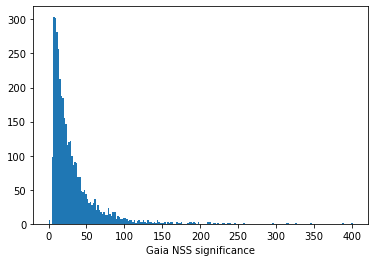

In [16]:
plt.hist(jokerall["significance"], bins=200);
plt.xlabel("Gaia NSS significance");

143 systems at Gaia significance > 10 and joker unimodal


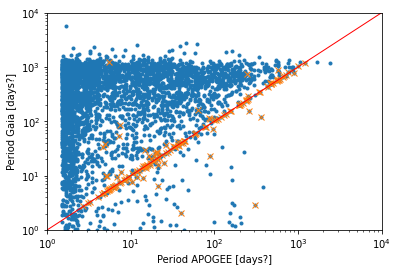

In [17]:
plt.plot(jokerall["MAP_P"], jokerall["period"], '.')
ii1 = jokerall["significance"] > 10 # arbitrary, somewhat did this in a DR3 paper
ii2 = jokerall["unimodal"] # quality cut from Adrian's Joker tutorial; means there is a unimodal posterier
ii = ii1 & ii2
print(ii.sum(),"systems at Gaia significance > 10 and joker unimodal")
plt.plot(jokerall[ii]["MAP_P"], jokerall[ii]["period"], 'x')
plt.loglog()
plt.xlabel("Period APOGEE [days?]")
plt.ylabel("Period Gaia [days?]")
xmin, xmax = 1, 10000
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.plot([xmin,xmax],[xmin,xmax],'r-', lw=1)

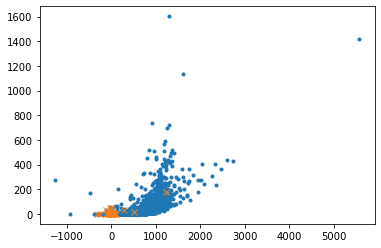

In [18]:
jokerall["perioddiff"] = jokerall["period"] - jokerall["MAP_P"]
plt.plot(jokerall["perioddiff"], jokerall["period_error"], '.')
plt.plot(jokerall["perioddiff"][ii], jokerall["period_error"][ii], 'x')
